In [2]:
import math
import random
from typing import Dict, List,Tuple
import requests

import time

import numpy as np
import matplotlib.pyplot as plt
import glob
from pathlib import Path, PurePath
import pathlib
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets
from torchvision import transforms

from PIL import Image

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import train_test_split

from imutils import paths

#import splitfolders
import textwrap

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil
import seaborn as sns
from sklearn.metrics import classification_report, f1_score
import random
from PIL import Image


In [3]:
# Set seaborn style for plots
sns.set_style('darkgrid')

# Download and extract the dataset
CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = '100-bird-species:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F534640%2F5468571%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240526%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240526T093952Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1e6bc8e6ce4f714774ff75fee98e90710ed5280580365385490e7e571f866ef0486845ff22d7b2c81ac06a993766d8f4cae64bd15f96a8463908af25bbba4387281516bd5d53b49ee026b682539bdb84cb29adb2a7bea44eabff32018e08bc73f40af09ee9b13ea1a21083c840b32f48d75a80159efa95c526b48ced867d573754b5a3c29ba4f6e2f05aa3ad059cf2ba33d60e6dc4dde14b6cd5834e64477eca9090381d6324e62a6afa6d35720dcd2d268fec1c9266593e4df5fdad6dc0f3089bc591227b6f323408987c07f7254439d50a3ff2f370b8b0fa7d470bea0f5626af1fc5a627c1109e7a46298d99d156a82023f9a74c63f01341db3192e4b1654d'

KAGGLE_INPUT_PATH = '/kaggle/input'
KAGGLE_WORKING_PATH = '/kaggle/working'
KAGGLE_SYMLINK = 'kaggle'

# Unmount and remove previous input directory if exists
!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

# Create symlinks
try:
    os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
    pass
try:
    os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
    pass


In [4]:
# Download and unzip the dataset
for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
                with ZipFile(tfile) as zfile:
                    zfile.extractall(destination_path)
            else:
                with tarfile.open(tfile.name) as tarfile:
                    tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 2099628449 bytes downloaded
Downloaded and uncompressed: 100-bird-species
Data source import complete.


In [5]:
def count_subdirectories(path: str) -> int:
    """
    Counts the number of subdirectories in the given directory path.
    """
    dir_path = Path(path)
    subdirectories = [f for f in dir_path.iterdir() if f.is_dir()]
    return len(subdirectories)


In [8]:
class config:
    # specify the paths to datasets
    ROOT_DIR = Path('/kaggle/input/100-bird-species')
    TRAIN_DIR = ROOT_DIR.joinpath('train')
    TEST_DIR = ROOT_DIR.joinpath('test')
    VAL_DIR = ROOT_DIR.joinpath('valid')

    # set the input height and width
    INPUT_HEIGHT = 224
    INPUT_WIDTH = 224

    # set the input height and width
    IMAGENET_MEAN = [0.485, 0.456, 0.406]
    IMAGENET_STD = [0.229, 0.224, 0.225]

    IMAGE_TYPE = '.jpg'
    BATCH_SIZE = 128
    MODEL_NAME = 'resnet50'
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    TRAINING_PARAMS = 'training_hyperparams/imagenet_resnet50_train_params'

    NUM_CLASSES = 50  # Assuming we have 50 classes after filtering
    CHECKPOINT_DIR = 'checkpoints'



In [9]:


import cv2
from imutils import paths
from pathlib import PurePath

def count_subdirectories(path: str) -> int:
    dir_path = Path(path)
    subdirectories = [f for f in dir_path.iterdir() if f.is_dir()]
    return len(subdirectories)

# Count subdirectories and print the number
parent_dir = config.TRAIN_DIR
num_subdirectories = count_subdirectories(parent_dir)
print(f"Number of subdirectories in {parent_dir}: {num_subdirectories}")

train_image_path_list = list(sorted(paths.list_images(config.TRAIN_DIR)))
train_image_path_sample = random.sample(population=train_image_path_list, k=20)



Number of subdirectories in /kaggle/input/100-bird-species/train: 525


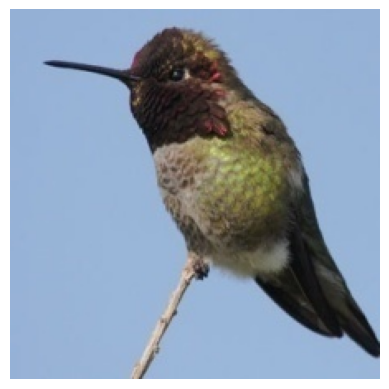

Figures are  (224, 224, 3)


In [13]:

from keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator

IMAGE = load_img("/kaggle/input/100-bird-species/train/ANNAS HUMMINGBIRD/025.jpg")
plt.imshow(IMAGE)
plt.axis("off")
plt.show()

IMAGEDATA = img_to_array(IMAGE)
SHAPE = IMAGEDATA.shape
print('Figures are ', SHAPE)

In [14]:
BASE_DIR = '/kaggle/input/100-bird-species'
print('BASE_DIR contains ', os.listdir(BASE_DIR))
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALIDATION_DIR = os.path.join(BASE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DIR, 'test')

BASE_DIR contains  ['birds.csv', 'valid', 'test', 'EfficientNetB0-525-(224 X 224)- 98.97.h5', 'train']


In [15]:
CATEGORIES = os.listdir(TRAIN_DIR)
print(str(len(CATEGORIES)),'CATEGORIES are ', CATEGORIES)

Category_count = len(CATEGORIES)

525 CATEGORIES are  ['COLLARED CRESCENTCHEST', 'AMETHYST WOODSTAR', 'RUFOUS TREPE', 'HIMALAYAN MONAL', 'TROPICAL KINGBIRD', 'IBERIAN MAGPIE', 'BROWN HEADED COWBIRD', 'HOATZIN', 'BAND TAILED GUAN', 'GURNEYS PITTA', 'BLACK THROATED HUET', 'D-ARNAUDS BARBET', 'COMMON STARLING', 'GRAY KINGBIRD', 'GREATER PRAIRIE CHICKEN', 'COMMON LOON', 'JABIRU', 'GILA WOODPECKER', 'SPOTTED CATBIRD', 'PALILA', 'DUSKY LORY', 'OILBIRD', 'GREATOR SAGE GROUSE', 'WHITE BROWED CRAKE', 'BLUE GROSBEAK', 'SURF SCOTER', 'AFRICAN OYSTER CATCHER', 'VULTURINE GUINEAFOWL', 'AMERICAN WIGEON', 'ABBOTTS BABBLER', 'CHESTNET BELLIED EUPHONIA', 'GREAT POTOO', 'CRESTED AUKLET', 'BLACK NECKED STILT', 'CANARY', 'ELEGANT TROGON', 'GOLDEN PHEASANT', 'CRESTED CARACARA', 'BAIKAL TEAL', 'YELLOW HEADED BLACKBIRD', 'GREAT KISKADEE', 'CARMINE BEE-EATER', 'INDIAN ROLLER', 'NORTHERN FLICKER', 'MALAGASY WHITE EYE', 'CAPE MAY WARBLER', 'SNOW GOOSE', 'BLUE GROUSE', 'KING VULTURE', 'VERMILION FLYCATHER', 'COMMON POORWILL', 'HARPY EAGLE', 'SNO

In [16]:
General_datagen = ImageDataGenerator(rescale=1./255, )

In [17]:
train_data = General_datagen.flow_from_directory(TRAIN_DIR, target_size=(224,224))
print('data groups:', len(train_data)) #Will be used to determine steps_per_epoch in my models.
Train_groups = len(train_data)
validation_data = General_datagen.flow_from_directory(VALIDATION_DIR, target_size=(224,224),)
image_qty = len(validation_data.filenames)
print('data groups:', len(validation_data))
print('validation image qty:',str(image_qty))
Valid_groups = len(validation_data)
test_data = General_datagen.flow_from_directory(TEST_DIR, target_size=(224,224),)
print('data groups:', len(test_data))

Found 84635 images belonging to 525 classes.
data groups: 2645
Found 2625 images belonging to 525 classes.
data groups: 83
validation image qty: 2625
Found 2625 images belonging to 525 classes.
data groups: 83


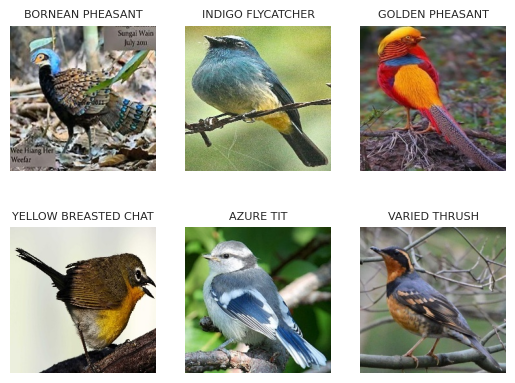

In [18]:
def label_images2(DIR, dataset):
    label = []
    image = []
    j=0
    for i in range (0,30):
        j = random.randint(0, len(dataset.filenames))
        label.append(dataset.filenames[j].split('/')[0])
        image.append(DIR + '/' + dataset.filenames[j])
    return [label,image]

#plot the random images.
y,x = label_images2(TEST_DIR, test_data)

for i in range(0,6):
    X = load_img(x[i])
    plt.subplot(2,3,+1 + i)
    plt.axis(False)
    plt.title(y[i], fontsize=8)
    plt.imshow(X)
plt.show()

In [24]:

from tensorflow.keras import backend, models
import tensorflow as tf
from keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical #Image generator used for transformation to categorical
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras import backend, models
#from sklearn.model_selection import train_test_split  #could have used on the consolidated file.
from sklearn.metrics import confusion_matrix

from tensorflow.keras.applications import VGG16, MobileNet
#from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model, Sequential

In [ ]:
backend.clear_session()
model = Sequential()

model.add(Conv2D(64, (3, 3), padding='same',input_shape=SHAPE)) #224X224
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3))) #222x222
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #111x111
model.add(BatchNormalization())
model.add(Dropout(0.35)) #Doesn't appear to be working in the model summary.

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3))) #109x109
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #54x54
model.add(BatchNormalization())
model.add(Dropout(0.35)) #64 --> 42

model.add(Conv2D(64, (3, 3), padding='same')) #54x54
model.add(Activation('relu'))
model.add(BatchNormalization())



model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dense(Category_count)) #Updated for number of classes
model.add(Activation('softmax'))

model.summary()

#Compile
model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True),
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])
#fit model
history = model.fit_generator(
    train_data,
    steps_per_epoch = Train_groups,
    epochs = 50,
    validation_data = validation_data,
    validation_steps = Valid_groups,
    verbose = 1,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience = 5, restore_best_weights = True),
               ReduceLROnPlateau(monitor = 'val_loss', factor = 0.7, #0.2 to 0.5 dropped to fast 0.7
                                 patience = 2, verbose = 1)])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 activation (Activation)     (None, 224, 224, 64)      0         
                                                                 
 batch_normalization (Batch  (None, 224, 224, 64)      256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 64)      36928     
                                                                 
 activation_1 (Activation)   (None, 222, 222, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 64)      0         
 D)                                                     

<ipython-input-27-d79804bc2c3d>:45: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
  13/2645 [..............................] - ETA: 16:01:07 - loss: 6.6534 - accuracy: 0.0024